# Content-Based Music Recommendation

@author: Aman Sharma (z5492132)

The task is to
build a content-based “music recommender” such as might be used by a streaming service (such
as Spotify) to give users a personalized playlist of songs that match their interests.

The dataset is a collection of 1500 songs that have been labelled as one of
5 main topics: dark, emotion, lifestyle, personal and sadness. The songs are in a single .tsv file
with 6 fields: artist name, track name, release date, genre, lyrics and topic.

The work done is in 3 Parts:
1. Topic Classification
2. Recommendation Methods
3. User Evaluation



### Data Exploration


In [1]:
import pandas as pd

# load the data set
songs_df = pd.read_csv('/content/drive/MyDrive/Comp9727 - Assignment 1/dataset.tsv', sep='\t')

In [2]:
print("Dataset Info:")
songs_df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB


In [3]:
print("First 10 rows:")
print(songs_df.head(10)) # get the dataset strcuture

First 10 rows:
                            artist_name                       track_name  \
0                                loving                the not real lake   
1                               incubus                  into the summer   
2                             reignwolf                         hardcore   
3                  tedeschi trucks band                           anyhow   
4  lukas nelson and promise of the real                if i started over   
5                               tia ray                     just my luck   
6                            rebelution                        trap door   
7                   thank you scientist  the amateur arsonist's handbook   
8                            zayde wølf                        gladiator   
9                        eli young band                       never land   

   release_date    genre                                             lyrics  \
0          2016     rock  awake know go see time clear world mirror w

In [4]:
print(songs_df.isnull().sum()) # missing values

artist_name     0
track_name      0
release_date    0
genre           0
lyrics          0
topic           0
dtype: int64


In [5]:
print(songs_df['topic'].value_counts())

topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


In [6]:
import re

def contains_special_char(text):
    """
    Returns True if the text contains any special characters
    @param text: text to check
    """
    return bool(re.search(r"[^\w\s'-@!]", str(text)))

In [7]:
special_char_mask = songs_df.map(contains_special_char)

print("Special Character Counts Per Column:")
print(special_char_mask.sum())

Special Character Counts Per Column:
artist_name     39
track_name      42
release_date     0
genre            0
lyrics           0
topic            0
dtype: int64


### Dataset analysis:

- There is no null vales
- There are 6 colums:
  1.   Artist Name
  2.   Track Name
  3.   Release Date
  4.   Genre
  5.   Lyrics
  6.   Topic

  Considerations to keep in mind:
  - The dataset is not balanced by topic. The dataset has significantly more `dark` and `sadness` songs then lowest one the `emotion` topic.
  - The dataset does contain some special character in the artist names and track names columns.



---



## Part 1 - Topic Classification

Import and Download necessary libraries



In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Defining the Stop-Words and Lemmatizer

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

1) There are a few simplifications in the Jupyter notebook in the tutorial: (i) the regex might remove too many special characters

Preprocessing function that addresses the tutorial codes limitations:
- converts text to lowercase
- tokenizes, removes stopwords, and lemmatizes tokens.

With the recommendation system we are trying to create we need to consider the ways in which artist names and track names are used. Therefore, we need to keep them in for our case of content based music recommendation. Cases to consier would be similar names with special characters in the names to differentiate.

In [11]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    """
    Tutorial Preprocessing Function
    @param text: text to preprocess
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

In [12]:
# join all fields other than Topic for Topic Classificiation
fields_to_join = ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']
songs_df['document'] = songs_df[fields_to_join].fillna('').astype(str).agg(' '.join, axis=1)

songs_df['cleaned_doc'] = songs_df['document'].apply(preprocess)
songs_df['cleaned_doc'].head(10) # In document it should have the all the fields that we want to cobine for topic classification
songs_df['document'].head(10)

,document
0,loving the not real lake 2016 rock awake know ...
1,incubus into the summer 2019 rock shouldn summ...
2,reignwolf hardcore 2016 blues lose deep catch ...
3,tedeschi trucks band anyhow 2016 blues run bit...
4,lukas nelson and promise of the real if i star...
5,tia ray just my luck 2018 jazz yeah happen rea...
6,rebelution trap door 2018 reggae long long ro...
7,thank you scientist the amateur arsonist's han...
8,zayde wølf gladiator 2018 rock start climb fac...
9,eli young band never land 2017 country word ye...


Import necessary Libraries

1) There are a few simplifications in the Jupyter notebook in the tutorial:
(ii) the evaluation is based on only one training-
test split rather than using cross-validation. Explain how you are going to fix these mistakes and then highlight any changes to the code in the answers to the next questions.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# define the count vectorizer for BernoulliNB
vectorizer = CountVectorizer()

# transform the cleaned text into binary feature vectors
X_bnb = vectorizer.fit_transform(songs_df['cleaned_doc'])
y_bnb = songs_df['topic']

In [14]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bnb, songs_df['topic'], test_size=0.2, random_state=42)

In [15]:
from sklearn.naive_bayes import BernoulliNB

# BernoulliNB model:
bnb = BernoulliNB()

In [17]:
# train the model
bnb.fit(X_train, y_train)

BernoulliNB()

In [18]:
from sklearn.metrics import accuracy_score, classification_report

# predict the categories of the test set
y_pred = bnb.predict(X_test)

# display accuracy and classification report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5133333333333333
              precision    recall  f1-score   support

        dark       0.60      0.74      0.66       102
     emotion       0.00      0.00      0.00        11
   lifestyle       0.25      0.03      0.05        37
    personal       0.78      0.27      0.40        77
     sadness       0.41      0.78      0.54        73

    accuracy                           0.51       300
   macro avg       0.41      0.36      0.33       300
weighted avg       0.53      0.51      0.47       300



From the tutorial code we have low accuracy for our case especially with there being severely imbalanced classes the model does not learn to predict emotion and lifestyle very well. This can be seen directly due to the class imbalances  found during data exploration.

`
topic
dark:         490,
sadness:      376,
personal:     347,
lifestyle:    205,
emotion:       82,
`

To fix this we will be using stratified k-fold cross-validation.

In [19]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# stratified k-fold cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# custom scorers with taking into account of zero_division = 0
precision_macro = make_scorer(precision_score, average='macro', zero_division=0)
recall_macro = make_scorer(recall_score, average='macro', zero_division=0)
f1_macro = make_scorer(f1_score, average='macro', zero_division=0)

In [21]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# perform cross-validation and collect scores
bnb_cv_results = cross_validate(
    bnb,
    X_bnb,
    y_bnb,
    cv=cv_strategy,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    },
    return_train_score=True
)

In [22]:
import numpy as np

# displaying the Scores
for metric in ['train_accuracy', 'test_accuracy',
               'train_precision_macro', 'test_precision_macro',
               'train_recall_macro', 'test_recall_macro',
               'train_f1_macro', 'test_f1_macro']:
    mean = np.mean(bnb_cv_results[metric])
    std = np.std(bnb_cv_results[metric])
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

train_accuracy: 0.7778 ± 0.0085
test_accuracy: 0.5327 ± 0.0173
train_precision_macro: 0.7825 ± 0.0662
test_precision_macro: 0.4110 ± 0.0325
train_recall_macro: 0.5951 ± 0.0085
test_recall_macro: 0.3888 ± 0.0120
train_f1_macro: 0.5801 ± 0.0093
test_f1_macro: 0.3524 ± 0.0116


(ii) This completes the full BernoulliNB training cycle with robust evaluation. (as can be seen from the code above) Metrics are stable across folds and computed safely without undefined cases.

2) Now considering all the steps in text preprocessing used prior to classification with both BNB and MNB. The aim here is to find preprocessing steps that maximize overall accuracy (under the default settings of the classifiers and using CountVectorizer with the standard settings). Considering the special characters to be removed (and how and when they are removed),
the definition of a “word”, the stopword list, lowercasing and stemming/lemmatization. Summarize the preprocessing steps that you think work “best” overall and do not change this for the rest of the assignment.


1. Choice of Stemmer: Here we are using the Snowball Stemmer as it is more efficient and effectivle a better version of the Porter Stemmer. The Snowball stemmer is way more aggressive than Porter Stemmer and is also referred to as Porter2 Stemmer. Because of the improvements added when compared to the Porter Stemmer, the Snowball stemmer is having greater computational speed.

2. Choice of Regex: I have removed all the special characters in the lyrics and converted it all to lowercase. This should better allow the model to gage it better and learn to classify more efficiently.

3. Definition of Word: Considering the words as their best possible stem without losing the meaning or understanding in the larger song lyrics for each song.

4. Stopwords are from the NLTK library.

These were the key preprocessing steps I used to try maximise accuracy.

Note the preprocessing steps done in the `final_preprocessing_text` function has only been applied to the lyrics and not to any of the other fields. This is as:
- 'artist_name',
- 'track_name',
- 'release_date',
- 'genre',

should not have any major preprocessing done to them as it can not be done without losing the meaning/context/syntactic importance.


In [23]:
from nltk.stem import SnowballStemmer

snowball = SnowballStemmer('english')

def final_preprocess_text(text):
    """
    Final Preprocessing Function
    @param text: text to preprocess
    """
    text = re.sub(r"[^\w\s']", '', text) # remove all special characters
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [snowball.stem(word) for word in tokens]
    return ' '.join(tokens)

# apply preprocessing to each document
songs_df['cleaned_lyrics'] = songs_df['lyrics'].apply(final_preprocess_text) # fcd = final cleaned document
songs_df['cleaned_lyrics'].head(10)

,cleaned_lyrics
0,awak know go see time clear world mirror world...
1,summer pretti build spill readi overflow piss ...
2,lose deep catch breath think say tri break wal...
3,run bitter tast take rest feel anchor soul pla...
4,think think differ set apart sober mind sympat...
5,yeah happen real drink drink turn shot lose co...
6,long long road occur look shortcut wan na caus...
7,quick think good true worst best thing forev p...
8,start climb face armi viper lion reach caus ti...
9,word yeah wreck roll lip high good get bottl r...


In [24]:
# join all fields other than Topic for Topic Classificiation
fields_to_join = ['artist_name', 'track_name', 'release_date', 'genre', 'cleaned_lyrics']
songs_df['cfd'] = songs_df[fields_to_join].fillna('').astype(str).agg(' '.join, axis=1) # cleaned final document

songs_df['cfd'].head(10)

,cfd
0,loving the not real lake 2016 rock awak know g...
1,incubus into the summer 2019 rock summer prett...
2,reignwolf hardcore 2016 blues lose deep catch ...
3,tedeschi trucks band anyhow 2016 blues run bit...
4,lukas nelson and promise of the real if i star...
5,tia ray just my luck 2018 jazz yeah happen rea...
6,rebelution trap door 2018 reggae long long roa...
7,thank you scientist the amateur arsonist's han...
8,zayde wølf gladiator 2018 rock start climb fac...
9,eli young band never land 2017 country word ye...


Checking performance of BNB model with updated preprocessing:

In [25]:
# transform the cleaned text into binary feature vectors
X_bnb = vectorizer.fit_transform(songs_df['cfd'])
y_bnb = songs_df['topic']

In [26]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# stratified k-fold cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [27]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# custom scorers with taking into account of zero_division = 0
precision_macro = make_scorer(precision_score, average='macro', zero_division=0)
recall_macro = make_scorer(recall_score, average='macro', zero_division=0)
f1_macro = make_scorer(f1_score, average='macro', zero_division=0)

In [28]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# perform cross-validation and collect scores
bnb_cv_results = cross_validate(
    bnb,
    X_bnb,
    y_bnb,
    cv=cv_strategy,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    },
    return_train_score=True
)

In [29]:
import numpy as np

# displaying the scores
for metric in ['train_accuracy', 'test_accuracy',
               'train_precision_macro', 'test_precision_macro',
               'train_recall_macro', 'test_recall_macro',
               'train_f1_macro', 'test_f1_macro']:
    mean = np.mean(bnb_cv_results[metric])
    std = np.std(bnb_cv_results[metric])
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

train_accuracy: 0.7798 ± 0.0067
test_accuracy: 0.5387 ± 0.0180
train_precision_macro: 0.7833 ± 0.0663
test_precision_macro: 0.4372 ± 0.0686
train_recall_macro: 0.5943 ± 0.0074
test_recall_macro: 0.3916 ± 0.0125
train_f1_macro: 0.5768 ± 0.0088
test_f1_macro: 0.3531 ± 0.0118


With the refined preprocess we can see a clear improvement in the performance metrics:

This was with unrefined preprocessing:

```
train_accuracy: 0.7778 ± 0.0085
test_accuracy: 0.5327 ± 0.0173
train_precision_macro: 0.7825 ± 0.0662
test_precision_macro: 0.4110 ± 0.0325
train_recall_macro: 0.5951 ± 0.0085
test_recall_macro: 0.3888 ± 0.0120
train_f1_macro: 0.5801 ± 0.0093
test_f1_macro: 0.3524 ± 0.0116

```

This is with the new refined preprocessing:
```
train_accuracy: 0.7798 ± 0.0067
test_accuracy: 0.5387 ± 0.0180
train_precision_macro: 0.7833 ± 0.0663
test_precision_macro: 0.4372 ± 0.0686
train_recall_macro: 0.5943 ± 0.0074
test_recall_macro: 0.3916 ± 0.0125
train_f1_macro: 0.5768 ± 0.0088
test_f1_macro: 0.3531 ± 0.0118
```

There are clear improvements accross the board with the new changes made with the text preprocessing. Especially with regard to accuracy metrics which we are trying to optimise for.

2) Now Developing a Multinomial Naive Bayes (MNB) model.

In [30]:
# vectorisation using CountVectorizer
vectorizer = CountVectorizer()
X_mnb = vectorizer.fit_transform(songs_df['cfd'])
y_mnb = songs_df['topic']

In [31]:
print(f"Shape of cfd-topic matrix: {X_mnb.shape}")

Shape of cfd-topic matrix: (1500, 9532)


In [32]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

# stratified cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
# evaluation metrics with safe division handling
precision_macro = make_scorer(precision_score, average='macro', zero_division=0)
recall_macro = make_scorer(recall_score, average='macro', zero_division=0)
f1_macro = make_scorer(f1_score, average='macro', zero_division=0)

In [34]:
# perform cross-validation
mnb_cv_results = cross_validate(
    mnb,
    X_mnb,
    y_mnb,
    cv=cv_strategy,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    },
    return_train_score=True
)


In [35]:
# display desults
for metric in ['train_accuracy', 'test_accuracy',
               'train_precision_macro', 'test_precision_macro',
               'train_recall_macro', 'test_recall_macro',
               'train_f1_macro', 'test_f1_macro']:
    mean = np.mean(mnb_cv_results[metric])
    std = np.std(mnb_cv_results[metric])
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

train_accuracy: 0.9808 ± 0.0032
test_accuracy: 0.7773 ± 0.0129
train_precision_macro: 0.9843 ± 0.0029
test_precision_macro: 0.7458 ± 0.0380
train_recall_macro: 0.9583 ± 0.0050
test_recall_macro: 0.6883 ± 0.0129
train_f1_macro: 0.9698 ± 0.0042
test_f1_macro: 0.7042 ± 0.0196


**Comparing the results between the BNB and MNB models.**

Looking at final test scores and macro scores only:

|      Metric       |       BNB       |        MNB      |
| ----------------- | --------------- | --------------- |
| Accuracy          | 0.5387 ± 0.0180 | 0.7773 ± 0.0129 |
| Precision (Macro) | 0.4372 ± 0.0686 | 0.7458 ± 0.0380 |
| Recall (Macro)    | 0.3916 ± 0.0125 | 0.6883 ± 0.0129 |
| F1 Score (Macro)  | 0.3531 ± 0.0118 | 0.7042 ± 0.0196 |

In all the cases we can clearly see that the **MNB** model performs significantly btter than the BNB model.

Below is a plot of how the models performed respectively shown visually.


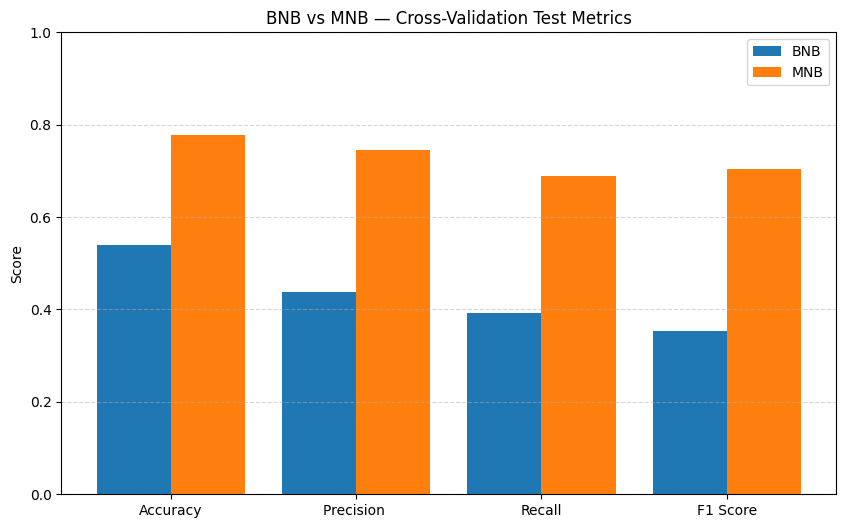

In [36]:
import matplotlib.pyplot as plt

# metrics results for visual comparison
metrics = ['Accuracy', 'Precision ', 'Recall', 'F1 Score']
bnb_scores = [0.5387, 0.4372, 0.3916, 0.3531]
mnb_scores = [0.7773, 0.7458, 0.6883, 0.7042]

x = range(len(metrics))
plt.figure(figsize=(10, 6))
plt.bar(x, bnb_scores, width=0.4, label='BNB')
plt.bar([i + 0.4 for i in x], mnb_scores, width=0.4, label='MNB')
plt.xticks([i + 0.2 for i in x], metrics)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("BNB vs MNB — Cross-Validation Test Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

3) Analysing the Results of BNB and MNB on cross validation:

- BNB underperforms significantly across all metrics, particularly in recall and F1, which suggests that it struggles to generalize to all topic classes equally.
- MNB, by contrast, generalizes much better, with more balanced train/test metrics. Its use of word frequencies allows it to capture more nuanced patterns in the lyrics.
- The macro-averaged metrics reflect the classifier's ability to perform fairly across all classes, which is important given the class imbalances:
```
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
```


Thus, in conclusion:

Multinomial Naive Bayes (MNB) performs noticeably better than Bernoulli Naive Bayes (BNB) based on cross-validation performance. Better generalization and class balance are indicated by its noticeably improved test accuracy and F1 scores.

As a result, MNB will be our model of choice for topic classification.



In [37]:
# sizes to test
vocab_sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, None]
bnb_scores = {'accuracy': [], 'f1': []}
mnb_scores = {'accuracy': [], 'f1': []}

# Evaluation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average='macro', zero_division=0)

# test for each N (500 : ALL_WORDS)
for max_n in vocab_sizes:
    label = "All" if max_n is None else str(max_n)

    vectorizer = CountVectorizer(max_features=max_n)
    X = vectorizer.fit_transform(songs_df['cfd'])
    y = songs_df['topic']

    bnb_results = cross_validate(bnb, X, y, cv=cv_strategy,
                                 scoring={'acc': 'accuracy', 'f1': f1_macro},
                                 return_train_score=False)
    bnb_scores['accuracy'].append(np.mean(bnb_results['test_acc']))
    bnb_scores['f1'].append(np.mean(bnb_results['test_f1']))

    mnb_results = cross_validate(mnb, X, y, cv=cv_strategy,
                                 scoring={'acc': 'accuracy', 'f1': f1_macro},
                                 return_train_score=False)
    mnb_scores['accuracy'].append(np.mean(mnb_results['test_acc']))
    mnb_scores['f1'].append(np.mean(mnb_results['test_f1']))


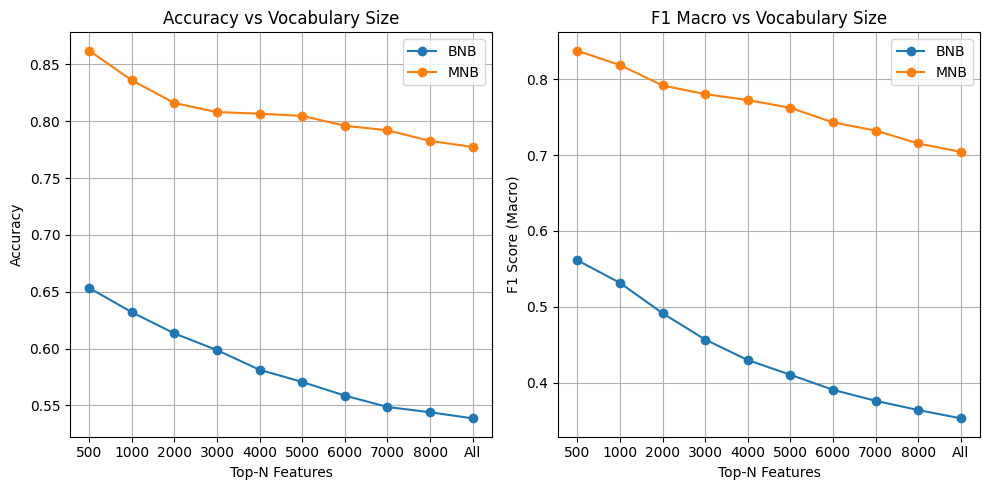

In [38]:
# vocab_sizes for x-axis labels
x_labels = ['500', '1000', '2000', '3000', '4000', '5000', '6000', '7000', '8000', 'All']

# plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_labels, bnb_scores['accuracy'], label='BNB', marker='o')
plt.plot(x_labels, mnb_scores['accuracy'], label='MNB', marker='o')
plt.title('Accuracy vs Vocabulary Size')
plt.xlabel('Top-N Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# plot macro F1 score
plt.subplot(1, 2, 2)
plt.plot(x_labels, bnb_scores['f1'], label='BNB', marker='o')
plt.plot(x_labels, mnb_scores['f1'], label='MNB', marker='o')
plt.title('F1 Macro vs Vocabulary Size')
plt.xlabel('Top-N Features')
plt.ylabel('F1 Score (Macro)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

4) MNB clearly out performs the BNB model in every vocabulary size. The highest accuracy achieved is with 500 features (words).

As the number of features increased the accuracy and F1 score dropped, sparsity increasing, possibly overfitting to noise.

Overall, it is decided to use `N=1000` as it has the best trade off aiming for a balance between performance and model simplicity.

5) **1. SVM** --> Because it is solid in high-dimensional spaces, such as those produced by bag-of-words models, supervised learning models like the Support Vector Machine (SVM) are frequently employed for text classification problems. Finding a hyperplane that maximally divides data points from various classes is how it operates. A one-vs-rest approach is used by scikit-learn library to accomplish this in the setting of multiclass classification. SVMs are perfect for text data because they work especially well with sparse feature representations. I believe that SVMs will perform better than naive Bayes models in this subject classification test given their great performance in previous NLP tasks, particularly when paired with tf-idf weighting and a small vocabulary.

In [39]:
vectorizer = CountVectorizer(max_features=1000)  # set to N = 1000 (from part 1.4)
X_svm = vectorizer.fit_transform(songs_df['cfd']) # using our cleaned final document (defined in 1.2)
y_svm = songs_df['topic']

In [40]:
from sklearn.svm import LinearSVC

# defining the modle
svm = LinearSVC(max_iter=5000) # set max iterations due to model failing to converge during trainin

In [41]:
# cross validation and metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro = make_scorer(f1_score, average='macro', zero_division=0)
recall_macro = make_scorer(recall_score, average='macro', zero_division=0)
precision_macro = make_scorer(precision_score, average='macro', zero_division=0)

In [42]:
# cross validation
svm_results = cross_validate(
    svm,
    X_svm,
    y_svm,
    cv=cv,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    },
    return_train_score=True
)

In [43]:
# results
for metric in svm_results:
    if "test" in metric or "train" in metric:
        print(f"{metric}: {np.mean(svm_results[metric]):.4f} ± {np.std(svm_results[metric]):.4f}")

test_accuracy: 0.8407 ± 0.0165
train_accuracy: 1.0000 ± 0.0000
test_precision_macro: 0.8297 ± 0.0197
train_precision_macro: 1.0000 ± 0.0000
test_recall_macro: 0.8114 ± 0.0364
train_recall_macro: 1.0000 ± 0.0000
test_f1_macro: 0.8188 ± 0.0282
train_f1_macro: 1.0000 ± 0.0000


This clearly performed much better than the BNB and MNB models. Thus, proving my hypothesis.
The final results for the modles compared is shown below:

|      Metric       |       BNB       |        MNB      |       SVM       |
| ----------------- | --------------- | --------------- |-----------------|
| Accuracy          | 0.5387 ± 0.0180 | 0.7773 ± 0.0129 | 0.8407 ± 0.0165 |
| Precision (Macro) | 0.4372 ± 0.0686 | 0.7458 ± 0.0380 | 0.8297 ± 0.0197 |
| Recall (Macro)    | 0.3916 ± 0.0125 | 0.6883 ± 0.0129 | 0.8114 ± 0.0364 |
| F1 Score (Macro)  | 0.3531 ± 0.0118 | 0.7042 ± 0.0196 | 0.8188 ± 0.0282 |



4) **2. BERT** To try a different approach I will use BERT. We expect BERT to outperform classical models (BNB, MNB, SVM) on recall and macro F1, particularly because it captures long-range dependencies and semantic feature in lyrics. This is something bag-of-words models cannot do.

In [44]:
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder

# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

songs = songs_df['document'].tolist()

# rncode labels
le = LabelEncoder()
labels = le.fit_transform(songs_df['topic'])
num_labels = len(le.classes_)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# tokenize all lyrics
encodings = tokenizer(songs, truncation=True, padding=True, max_length=512)

In [ ]:
import torch
from torch.utils.data import Dataset

class MusicDataSet(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

# build dataset
dataset = MusicDataSet(encodings, labels)

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# train-test split
train, test = train_test_split(range(len(dataset)), test_size=0.2, random_state=42, stratify=labels)

train_dataset = torch.utils.data.Subset(dataset, train)
eval_dataset = torch.utils.data.Subset(dataset, test)

# load pre-trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# training arguments
training_args = TrainingArguments(
    output_dir='./bert_output',
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir='./logs',
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {
        'accuracy': accuracy.compute(predictions=preds, references=p.label_ids)['accuracy'],
        'precision': precision.compute(predictions=preds, references=p.label_ids, average='macro', zero_division=0)['precision'],
        'recall': recall.compute(predictions=preds, references=p.label_ids, average='macro')['recall'],
        'f1': f1.compute(predictions=preds, references=p.label_ids, average='macro')['f1']
    }


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
 trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.334600,1.653837,0.710000,0.727699,0.656126,0.661955
2,0.286200,1.107823,0.813333,0.814347,0.732233,0.758156
3,0.120700,1.285211,0.813333,0.792829,0.794049,0.791262
4,0.051800,1.241449,0.833333,0.829485,0.780655,0.799888
5,0.009600,1.166257,0.843333,0.814805,0.840909,0.825351
6,0.008400,1.380225,0.833333,0.813719,0.848639,0.826650
7,0.001100,1.273754,0.836667,0.820955,0.836533,0.826561
8,0.000300,1.262578,0.833333,0.818380,0.833867,0.824228
9,0.000200,1.265640,0.833333,0.822518,0.833241,0.826287
10,0.000200,1.266544,0.836667,0.824834,0.835281,0.828672


TrainOutput(global_step=1500, training_loss=0.08132241158684095, metrics={'train_runtime': 299.5322, 'train_samples_per_second': 40.062, 'train_steps_per_second': 5.008, 'total_flos': 3120416720784000.0, 'train_loss': 0.08132241158684095, 'epoch': 10.0})

In [ ]:
eval_results = trainer.evaluate()

for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")

eval_loss: 1.1663
eval_accuracy: 0.8433
eval_precision: 0.8148
eval_recall: 0.8409
eval_f1: 0.8254
eval_runtime: 2.6162
eval_samples_per_second: 114.6680
eval_steps_per_second: 14.5250
epoch: 10.0000


The results for the BERT, were not as good as it should have been compared to. the other models which contradicts the hypothesis I had. This is likely due to the lack of data to properly train the BERT model. The model is prone to overfiting with smaller datasets.
The table of results for all the models compared thus far is shown below:


|      Metric       |       BNB       |        MNB      |       SVM       |    BERT    |
| ----------------- | --------------- | --------------- |-----------------|----|
| Accuracy          | 0.5387 ± 0.0180 | 0.7773 ± 0.0129 | 0.8407 ± 0.0165 | 0.8433 |
| Precision (Macro) | 0.4372 ± 0.0686 | 0.7458 ± 0.0380 | 0.8297 ± 0.0197 | 0.8148 |
| Recall (Macro)    | 0.3916 ± 0.0125 | 0.6883 ± 0.0129 | 0.8114 ± 0.0364 | 0.8409 |
| F1 Score (Macro)  | 0.3531 ± 0.0118 | 0.7042 ± 0.0196 | 0.8188 ± 0.0282 | 0.8254 |

From the results it is clear that BERT did perform the best over all but for such a large model compared to the SVM, the results were not nearly as much of an improvement as should be expected.

This all was likely due to the dataset being smaller with only 1500 songs which could've led to over fitting.


4) **3. DistillBERT**  is a distilled version of BERT that retains most of BERT's language understanding while being significantly smaller, faster, and more efficient. It is trained using knowledge distillation, where a smaller student model learns to mimic the behavior of a larger teacher model (BERT). This makes DistilBERT particularly useful for tasks like topic classification on moderate-sized datasets such as lyrics, where full BERT may overfit or struggle to converge effectively. We fine-tune DistilBERT using the same training setup as BERT to compare performance directly.

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# tokenizer for DistilBert
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

songs = songs_df['document'].tolist()

# encode labels
le = LabelEncoder()
labels = le.fit_transform(songs_df['topic'])
num_labels = len(le.classes_)

# tokenize all lyrics
encodings = tokenizer(songs, truncation=True, padding=True, max_length=512)

# build dataset
dataset = MusicDataSet(encodings, labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# train-test split
train, test = train_test_split(range(len(dataset)), test_size=0.2, random_state=42, stratify=labels)

train_dataset = torch.utils.data.Subset(dataset, train)
eval_dataset = torch.utils.data.Subset(dataset, test)

# pre-trained BERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# training arguments
training_args = TrainingArguments(
    output_dir='./distil_bert_output',
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir='./logs',
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.106900,0.960475,0.680000,0.781673,0.561234,0.567832
2,0.454600,0.814965,0.776667,0.803311,0.718395,0.738768
3,0.202800,0.950933,0.783333,0.779338,0.768277,0.763887
4,0.064900,1.059762,0.813333,0.805788,0.768902,0.778513
5,0.034800,0.926570,0.836667,0.828145,0.801233,0.810769
6,0.002200,0.990790,0.826667,0.799187,0.795891,0.797113
7,0.000800,1.001233,0.833333,0.817104,0.817814,0.815754
8,0.000800,1.001225,0.840000,0.819697,0.812070,0.815718
9,0.000500,1.007048,0.840000,0.819697,0.812070,0.815718
10,0.000500,1.010195,0.840000,0.819697,0.812070,0.815718


TrainOutput(global_step=1500, training_loss=0.18687969261407852, metrics={'train_runtime': 157.0957, 'train_samples_per_second': 76.387, 'train_steps_per_second': 9.548, 'total_flos': 1571064604560000.0, 'train_loss': 0.18687969261407852, 'epoch': 10.0})

In [ ]:
eval_results = trainer.evaluate()

for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")

eval_loss: 1.0012
eval_accuracy: 0.8400
eval_precision: 0.8197
eval_recall: 0.8121
eval_f1: 0.8157
eval_runtime: 1.1250
eval_samples_per_second: 266.6650
eval_steps_per_second: 33.7780
epoch: 10.0000


Similary DistilBERT's results were not as good as it should have been compared to the other models which contradicts the hypothesis I had.  
The table of results for all the models compared thus far is shown below:



|      Metric       |       BNB       |        MNB      |       SVM       |    BERT    | DistilBERT |
| ----------------- | --------------- | --------------- |-----------------|----|---|
| Accuracy          | 0.5387 ± 0.0180 | 0.7773 ± 0.0129 | 0.8407 ± 0.0165 | 0.8433 | 0.8400 |
| Precision (Macro) | 0.4372 ± 0.0686 | 0.7458 ± 0.0380 | 0.8297 ± 0.0197 | 0.8148 |  0.8197 |
| Recall (Macro)    | 0.3916 ± 0.0125 | 0.6883 ± 0.0129 | 0.8114 ± 0.0364 | 0.8409 | 0.8121 |
| F1 Score (Macro)  | 0.3531 ± 0.0118 | 0.7042 ± 0.0196 | 0.8188 ± 0.0282 | 0.8254 | 0.8157 |

From the results it is clear that BERT did perform the best over all but for such a large model compared to the SVM, the results were not nearly as much of an improvement as should be expected.

This all was likely due to the dataset being smaller with only 1500 songs which could've led to over fitting.

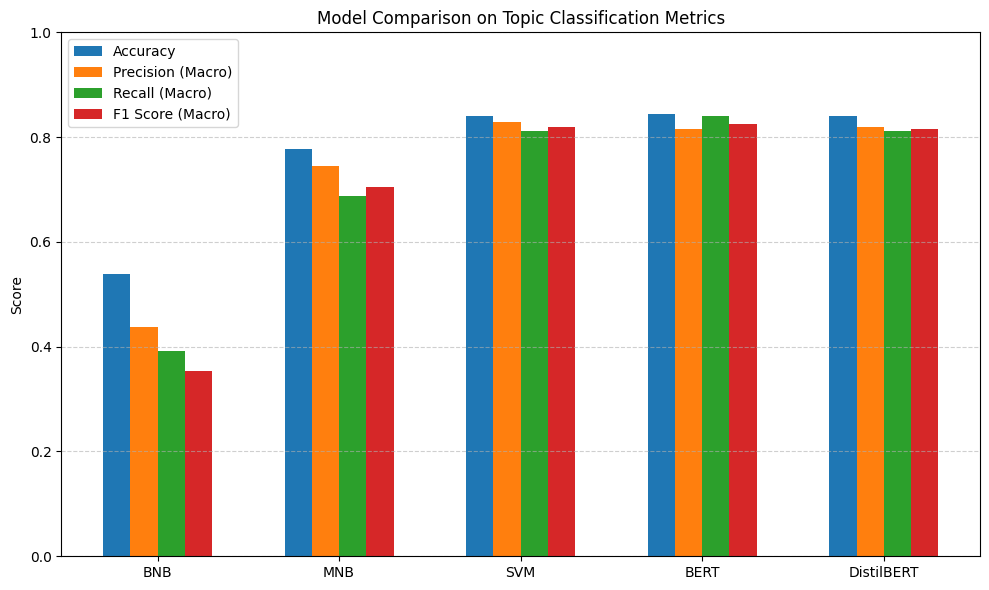

In [ ]:
models = ["BNB", "MNB", "SVM", "BERT", "DistilBERT"]
metrics = ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1 Score (Macro)"]

data = {
    "Accuracy": [0.5387, 0.7773, 0.8407, 0.8433, 0.8400],
    "Precision (Macro)": [0.4372, 0.7458, 0.8297, 0.8148, 0.8197],
    "Recall (Macro)": [0.3916, 0.6883, 0.8114, 0.8409, 0.8121],
    "F1 Score (Macro)": [0.3531, 0.7042, 0.8188, 0.8254, 0.8157]
}

values = np.array([data[metric] for metric in metrics])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15
x = np.arange(len(models))

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i * bar_width, values[i], width=bar_width, label=metric, color=color)

ax.set_xticks(x + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.set_ylabel("Score")
ax.set_title("Model Comparison on Topic Classification Metrics")
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In conclusion, I will be mainly using the SVM for the topic classification task as for the amount of data we have it performs the best considering all factors. It is a lighter weight model, especially compared to transformer based models with BERT and DistilBERT, and still has such a competitive overall performance.



---



## Part 2. Recommendation Methods

The aim is to use the information retrieval algorithms for “matching” user profiles to “documents” described in the lecture as a recommendation method. The overall idea is that the classifier from Part 1 will assign a new song to one of the 5 topics, and this song will be recommended to the user if the tf-idf vector for the song is similar to the tf-idf vector for the profile of the user in the predicted topic. The user profile for each topic will consist of the words, or top M words, representing the interests of the user in that topic, computed as a tf-idf vector across all songs predicted in that topic of interest to the user.

The “training data” for the user profiles and “test data” for the
recommender defined as follows. There are 1500 songs in each file. Suppose that the order in the
file is the time ordering of the songs, and suppose these songs came from a series of weeks, with 250
songs from each week. Assume Weeks 1–3 (songs 1–750) form the training data and Week 4 (songs
751–1000) are the test data.

Retrain SVM and on Weeks 1–3 and predict topics

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

# weeks 1-3 training
train = songs_df.iloc[:750].copy()

# convert doc to tfidf features
vectorizer = TfidfVectorizer(max_features=1000) # chosen N from Part 1.4
X_train = vectorizer.fit_transform(train['lyrics'])

# fit SVM
clf = LinearSVC(max_iter=10000)
clf.fit(X_train, train['topic'])

# predict topics on the training set
train["pred_topic"] = clf.predict(X_train)
print("true vs. predicted topics:")
print(train[["topic", "pred_topic"]].head(50))

true vs. predicted topics:
        topic pred_topic
0        dark       dark
1   lifestyle  lifestyle
2     sadness    sadness
3     sadness    sadness
4        dark       dark
5     emotion    emotion
6        dark       dark
7        dark       dark
8        dark       dark
9     sadness    sadness
10   personal   personal
11       dark       dark
12   personal   personal
13       dark       dark
14   personal   personal
15   personal   personal
16  lifestyle  lifestyle
17    sadness    sadness
18    emotion    emotion
19    sadness    sadness
20       dark       dark
21    sadness    sadness
22    sadness    sadness
23       dark       dark
24   personal   personal
25   personal   personal
26   personal   personal
27   personal   personal
28    sadness    sadness
29    sadness    sadness
30       dark       dark
31    sadness    sadness
32       dark       dark
33    emotion    emotion
34    emotion    emotion
35    sadness    sadness
36       dark       dark
37       dark       dar

Build a TF-IDF model for each predicted topic

In [46]:
topic_vectorizers = {}
for t in train["topic"].unique():
    docs = train.loc[train["pred_topic"] == t, "lyrics"].tolist()
    vec = TfidfVectorizer(max_features=1000)
    vec.fit(docs)
    topic_vectorizers[t] = vec

print("TF-IDF models for topics:", list(topic_vectorizers.keys()))

TF-IDF models for topics: ['dark', 'lifestyle', 'sadness', 'emotion', 'personal']


Load user keyword lists

In [47]:
u1 = pd.read_csv("/content/drive/MyDrive/Comp9727 - Assignment 1/user1.tsv", sep="\t",)
u2 = pd.read_csv("/content/drive/MyDrive/Comp9727 - Assignment 1/user2.tsv", sep="\t")

u1["keywords"] = u1["keywords"].str.replace(",", " ").str.split()
u2["keywords"] = u2["keywords"].str.replace(",", " ").str.split()

user1_kw = dict(zip(u1["topic"], u1["keywords"].apply(lambda lst: [w.lower() for w in lst])))
user2_kw = dict(zip(u2["topic"], u2["keywords"].apply(lambda lst: [w.lower() for w in lst])))

In [48]:
print(u1)

       topic                                  keywords
0       dark         [fire, enemy, pain, storm, fight]
1    sadness  [cry, alone, heartbroken, tears, regret]
2   personal    [dream, truth, life, growth, identity]
3  lifestyle       [party, city, night, light, rhythm]
4    emotion           [love, memory, hug, kiss, feel]


In [49]:
print(u2)

     topic                                 keywords
0  sadness  [lost, sorrow, goodbye, tears, silence]
1  emotion  [romance, touch, feeling, kiss, memory]


In [54]:
print('User 1: ', user1_kw)
print('')
print('User 2: ', user2_kw)

User 1:  {'dark': ['fire', 'enemy', 'pain', 'storm', 'fight'], 'sadness': ['cry', 'alone', 'heartbroken', 'tears', 'regret'], 'personal': ['dream', 'truth', 'life', 'growth', 'identity'], 'lifestyle': ['party', 'city', 'night', 'light', 'rhythm'], 'emotion': ['love', 'memory', 'hug', 'kiss', 'feel']}

User 2:  {'sadness': ['lost', 'sorrow', 'goodbye', 'tears', 'silence'], 'emotion': ['romance', 'touch', 'feeling', 'kiss', 'memory']}


In [55]:
# user 3 interests (based of my friend)
user3_kw = {
    'sadness': ['cry', 'alone', 'heartbroken'],
    'emotion': ['romance', 'touch', 'feeling', 'happy', 'love'],
    'personal': ['dream', 'truth'],
    'lifestyle': ['work', 'money'],
    'dark': ['death', 'disapear']
}

users = {
    "User 1": user1_kw,
    "User 2": user2_kw,
    "User 3": user3_kw,
}

In [56]:
# making each user’s topic-profile vector
user_profiles = {u: {} for u in users}

for user, kw_map in users.items():
    for topic, vec in topic_vectorizers.items():
        lyrics_list = train.loc[train["pred_topic"] == topic, "lyrics"]

        # select songs containing user’s keywords
        liked_docs = [
            txt for txt in lyrics_list
            if any(kw in txt.lower() for kw in kw_map.get(topic, []))
        ]

        if not liked_docs:
            user_profiles[user][topic] = None
            continue

        combined = " ".join(liked_docs)
        user_profiles[user][topic] = vec.transform([combined])

In [57]:
# top 20 terms per user per topic
for user, profiles in user_profiles.items():
    print(f"{user}:")
    for topic, profile_vec in profiles.items():
        print(f"\nTopic: {topic}")
        if profile_vec is None:
            print("  (no liked terms in this genre)")
            continue

        arr = profile_vec.toarray()[0]
        top_idx = np.argsort(arr)[::-1][:20]
        feature_names = topic_vectorizers[topic].get_feature_names_out()
        top_terms = [feature_names[i] for i in top_idx if arr[i] > 0]

        print("  ", top_terms)
    print("\n\n")

User 1:

Topic: dark
   ['fight', 'blood', 'like', 'grind', 'know', 'stand', 'come', 'yeah', 'tell', 'gonna', 'black', 'kill', 'dilly', 'lanky', 'hand', 'head', 'light', 'true', 'people', 'follow']

Topic: lifestyle
   ['tonight', 'night', 'come', 'home', 'closer', 'strangers', 'time', 'sing', 'long', 'wait', 'song', 'wanna', 'tire', 'spoil', 'right', 'struggle', 'yeah', 'mind', 'play', 'like']

Topic: sadness
   ['cry', 'club', 'steal', 'tear', 'mean', 'know', 'baby', 'music', 'write', 'say', 'think', 'true', 'smile', 'eye', 'face', 'word', 'want', 'blame', 'thrill', 'fear']

Topic: emotion
   ['good', 'touch', 'feel', 'hold', 'know', 'visions', 'video', 'loove', 'morning', 'vibe', 'feelin', 'want', 'go', 'miss', 'kiss', 'love', 'lovin', 'luck', 'gimme', 'sunrise']

Topic: personal
   ['life', 'live', 'change', 'know', 'world', 'ordinary', 'yeah', 'dream', 'wanna', 'like', 'thank', 'teach', 'lord', 'come', 'time', 'beat', 'think', 'learn', 'go', 'need']



User 2:

Topic: dark
  (no l

1) Across all three users, the highest-weight TF-IDF terms predominantly align with each topic’s theme and the users’ simulated keyword interests. A small number of generic or cross-topic words are inevitable given common lyric vocab, but the core thematic words are correctly surfaced.

In [108]:
from sklearn.metrics.pairwise import cosine_similarity

test = songs_df.iloc[750:1000].copy()
X_test = vectorizer.transform(test["lyrics"])

test["pred_topic"] = clf.predict(X_test)

# per-topic TF-IDF matrices for test
test_topic_vectors = {}
for topic, vec in topic_vectorizers.items():
    idxs = test[test["pred_topic"] == topic].index
    docs = test.loc[idxs, "lyrics"]
    if len(docs) > 0:
        test_topic_vectors[topic] = (idxs, vec.transform(docs))
    else:
        test_topic_vectors[topic] = (idxs, None)

In [109]:
N_REC = 5
M_values = [20, 50, None]   # None is when use all features

In [110]:
# dict of sets: relevant_test = {indices of relevant songs}
relevant_test = {user: {} for user in users}
for user, kw_map in users.items():
    for topic in topic_vectorizers:
        idxs = test[test["pred_topic"] == topic].index
        lyrics = test.loc[idxs, "lyrics"]
        rel = {
            idx for idx, txt in zip(idxs, lyrics)
            if any(kw in txt.lower() for kw in kw_map.get(topic, []))
        }
        relevant_test[user][topic] = rel

In [111]:
# make recs_dict
recs_dict = {}
for user in users:
    for M in M_values:
        M_key = M or "all"
        for topic, (idxs, vecs) in test_topic_vectors.items():
            prof_vec = user_profiles[user].get(topic)
            recs = []
            if vecs is not None and prof_vec is not None and len(relevant_test[user][topic]) > 0:
                arr = prof_vec.toarray()[0]
                if M is not None and M < arr.size:
                    top_idx = np.argpartition(arr, -M)[-M:]
                    mask = np.zeros_like(arr)
                    mask[top_idx] = arr[top_idx]
                    arr = mask
                sims = cosine_similarity(arr.reshape(1, -1), vecs).ravel()
                best = np.argsort(sims)[-N_REC:]
                recs = list(idxs[best])
            recs_dict[(user, M_key, topic)] = recs

In [128]:
# Hit rate at N=5
hit_rows = []
for user in users:
    for M in M_values:
        M_key = M or "all"
        hits = []
        for topic in test_topic_vectors:
            recs = recs_dict[(user, M_key, topic)]
            rel  = relevant_test[user][topic]
            hits.append(int(bool(set(recs) & rel)))
        hit_rate = sum(hits) / len(hits)
        hit_rows.append({"user": user, "M": M_key, "HitRate N=5": hit_rate})

hit_df = pd.DataFrame(hit_rows).set_index(["user","M"])
display(hit_df.round(3))

HitRate N=5
user   M               
User 1 20           1.0
       50           1.0
       all          1.0
User 2 20           0.2
       50           0.2
       all          0.4
User 3 20           0.8
       50           0.8
       all          0.8

In [127]:
# Mean average precision
map_rows = []
for user in users:
    for M in M_values:
        M_key = M or "all"
        ap_list = []
        for topic in test_topic_vectors:
            recs = recs_dict[(user, M_key, topic)]
            rel  = relevant_test[user][topic]
            hits = 0
            sum_prec = 0.0
            for i, idx in enumerate(recs, start=1):
                if idx in rel:
                    hits += 1
                    sum_prec += hits / i
            denom = min(len(rel), N_REC) or 1
            ap_list.append(sum_prec / denom)
        map_rows.append({"user": user, "M": M_key, "MAP N=5": np.mean(ap_list)})

map_df = pd.DataFrame(map_rows).set_index(["user","M"])
display(map_df)

MAP N=5
user   M            
User 1 20   0.540000
       50   0.594667
       all  0.594667
User 2 20   0.090000
       50   0.073333
       all  0.081333
User 3 20   0.165333
       50   0.195333
       all  0.168667

In [126]:
# Intra‐list diversity at N=5
from itertools import combinations

div_rows = []
for user in users:
    for M in M_values:
        M_key = M or "all"
        div_list = []
        for topic, (idxs, _) in test_topic_vectors.items():
            recs = recs_dict[(user, M_key, topic)]
            if len(recs) < 2:
                div_list.append(0.0)
            else:
                V = vectorizer.transform(songs_df.loc[recs, "lyrics"])
                sim_mat = cosine_similarity(V)
                diss = [1 - sim_mat[i,j] for i,j in combinations(range(len(recs)),2)]
                div_list.append(np.mean(diss))
        div_rows.append({"user": user, "M": M_key, "Diversity N=5": np.mean(div_list)})

div_df = pd.DataFrame(div_rows).set_index(["user","M"])
display(div_df)

Diversity N=5
user   M                 
User 1 20        0.754743
       50        0.755688
       all       0.797572
User 2 20        0.322914
       50        0.288489
       all       0.305548
User 3 20        0.873134
       50        0.872987
       all       0.884206

In [124]:
# precision values
precision_rows = []
for user in users:
    for M in M_values:
        M_key = M or "all"
        for topic in test_topic_vectors:
            recs = recs_dict[(user, M_key, topic)]
            rel  = relevant_test[user][topic]
            prec = len(set(recs) & rel) / N_REC
            precision_rows.append({
                "user": user,
                "M":    M_key,
                "topic": topic,
                "precision": prec
            })

precision_df = pd.DataFrame(precision_rows)

# make it a table
precision_table = (precision_df.pivot(index=["user","M"], columns="topic", values="precision"))
display(precision_table)

topic       dark  emotion  lifestyle  personal  sadness
user   M                                               
User 1 20    0.2      1.0        0.6       1.0      0.4
       50    0.2      1.0        0.6       1.0      0.6
       all   0.2      1.0        0.6       1.0      0.6
User 2 20    0.0      0.4        0.0       0.0      0.0
       50    0.0      0.4        0.0       0.0      0.0
       all   0.0      0.4        0.0       0.0      0.2
User 3 20    0.0      0.4        0.4       0.4      0.4
       50    0.0      0.4        0.4       0.4      0.4
       all   0.0      0.4        0.2       0.4      0.4

In [123]:
# recall values
recall_rows = []
for user in users:
    for M in M_values:
        M_key = M or "all"
        for topic in test_topic_vectors:
            recs = recs_dict[(user, M_key, topic)]
            rel  = relevant_test[user][topic]
            rec = len(set(recs) & rel) / len(rel) if rel else 0.0
            recall_rows.append({
                "user": user,
                "M":    M_key,
                "topic": topic,
                "recall": rec
            })

recall_df = pd.DataFrame(recall_rows)

# make it a table
recall_table = (recall_df.pivot(index=["user","M"], columns="topic", values="recall"))
display(recall_table)

topic           dark  emotion  lifestyle  personal   sadness
user   M                                                    
User 1 20   0.055556      0.5        0.2  0.135135  0.200000
       50   0.055556      0.5        0.2  0.135135  0.300000
       all  0.055556      0.5        0.2  0.135135  0.300000
User 2 20   0.000000      1.0        0.0  0.000000  0.000000
       50   0.000000      1.0        0.0  0.000000  0.000000
       all  0.000000      1.0        0.0  0.000000  0.125000
User 3 20   0.000000      0.5        0.4  0.133333  0.333333
       50   0.000000      0.5        0.4  0.133333  0.333333
       all  0.000000      0.5        0.2  0.133333  0.333333

Lets analyse the metrics for each user:

User 1:
- Precision improves as we expand
- Recall also improves as we expand
- Hit rate is always 1
- Mean average precision best result is the same at M=50 and all
- Best: using all profile words yields the highest precision and recall.

User 2:
- Hit rate at M = all gets the best results
- Mean average precision best result at M=all
- Diversity also has its best resilt at M=all
- Only the emotion topic gets non-zero scores for M = 20, 50, all in precision and recall
- In Recall and Precision for M = all there is value of sadness too, though it is small.
- Other topics have no keywords and thus zero precision/recall.
- note: expanding M cannot help when the profile itself is empty.

User 3
- Highest recall occurs at M = 20, 50 and precision is slightly higher at M = 20, 50 compared to M = all.
- Hitrate is constant across M = 20, 50, all
- Mean average precision is best at M = 50
- Diversity is best at M = all




Differences Between Users

- User 1 has a well-populated keyword lists produce decent precision and recall that steadily improve with more features.

- User 2, a more neiche user, has keywords in two topics, yielding nonzero performance one there.

- User 3 shows the trade-off. This being a smaller profile (top 20 words) recovers more relevant items (higher recall).

Results accross the 3 users:

| Profile size | Avg Precision | Avg Recall | Avg MAP | Avg Diversity | HitRate |
| -----------: | ------------: | ---------: | ------: | ------------: | ------: |
|     **M=20** |        0.3467 |      0.230 |   0.265 |         0.650 |   0.667 |
|     **M=50** |        0.3600 |      0.237 |   0.288 |         0.639 |   0.667 |
|      **all** |        0.3600 |      0.232 |   0.282 |         0.663 |   0.733 |

__My final matching algorithm choice will be M = all, this is as using all TF-IDF features yields the best results in the metircs I used__

---


## Part 3: User Evaluation


Conduct a “user study” of a hypothetical recommender system based on the method
chosen in Part 2. Your evaluation in Part 2 will have included a choice of the number N of songs
to show the user at any one time. For simplicity, suppose the user uses your system once per
week. Simulate running the recommender system for 3 weeks and training the model at the end
of Week 3 using interaction data obtained from the user, and testing the recommendations that
would be provided to that user in Week 4.



Choose one friendly “subject” and ask them to view (successively over a period of 4 simulated
weeks) N songs chosen at random for each “week”, for Weeks 1, 2 and 3, and then (after training
the model) the recommended songs from Week 4. The subject could be someone else from the
course, but preferably is someone without knowledge of recommendation algorithms who will give
useful and unbiased feedback.
To be more precise, the user is shown 3 randomly chosen batches of N songs, one batch from
Week 1 (N songs from 1–250), one batch from Week 2 (N songs from 251–500), and one batch
from Week 3 (N songs from 501–750), and says which of these they “like”. This gives training data
from which you can then train a recommendation model using the method in Part 2. The user is
then shown a batch of recommended songs from Week 4 (N songs from 751–1000) in rank order,
and metrics are calculated based on which of these songs the user likes. Show all these metrics in
a suitable form (plots or tables).



Ask the subject to talk aloud but make sure you find out which songs they are interested in.
Calculate and show the various metrics for the Week 4 recommended songs that you would show
using the model developed in Part 2. Explain any diﬀerences between metrics calculated in Part 2
and the metrics obtained from the real user. Finally, mention any general user feedback concerning
the quality of the recommendations.

Training phase and user likes retrival

In [80]:
N = 5   # number of songs shown per week
WEEKS = {
    1: (0, 249),
    2: (250, 499),
    3: (500, 749),
}
# using User 1 as my 'subject'
subject = "User 1"
kw_map  = users[subject]

In [71]:
# weeks 1-3 training
train = songs_df.iloc[:750].copy()
X_train = vectorizer.fit_transform(train["cleaned_lyrics"])
clf.fit(X_train, train["topic"])
train["pred_topic"] = clf.predict(X_train)

In [82]:
# make TF-IDF models on the classifier’s Week 1..3 predictions
topic_vectorizers = {}
for topic in train["pred_topic"].unique():
    docs = train.loc[train["pred_topic"] == topic, "lyrics"]
    vec = TfidfVectorizer(max_features=1000)
    vec.fit(docs)
    topic_vectorizers[topic] = vec


In [79]:
user_likes = {}

# show 5 songs for each week
for week, (start, end) in WEEKS.items():

    print('Week: ', week)
    batch_idxs = np.random.choice(np.arange(start, end+1), size=N, replace=False)
    display(songs_df.loc[batch_idxs, ["artist_name", "track_name", "lyrics"]])

Week:  1


,artist_name,track_name,lyrics
163,skillet,anchor,driftin beneath horizon body weak tryin shore ...
134,blues saraceno,wicked gonna come,wicked wicked gonna come wicked wicked gonna c...
16,post malone,spoil my night (feat. swae lee),come spoil night feelin come play thinkin happ...
70,scotty mccreery,this is it,mountains thousand feet high trail tree meet v...
94,tarrus riley,hurt me,think think settle wrong wrong think right par...


Week:  2


,artist_name,track_name,lyrics
395,deap vally,bring it on,think come brink guess think upper hand cause ...
270,thomas rhett,remember you young,buddies grow straightlaced marry foolin wasn l...
496,thee oh sees,poisoned stones,operation night suit eye lay basement awake ni...
440,bastille,blame,sleep fish room room wrap teeth pavement cause...
454,pisk,it ain't right,sleep pray lord soul angels watch night till m...


Week:  3


,artist_name,track_name,lyrics
624,bonobo,break apart,hard hate hard hate hate think careful careful...
537,steel pulse,thank the rebels,consolidation build brand nation yeah politica...
726,alessia cara,out of love,tell lonely cause selfish hold cause mend help...
636,novelists,under different welkins,scar live life vain crave better vibes hand ro...
619,brian culbertson,colors of love,look life tell human expect lose think safe ru...


Of the 3 weeks of songs the user liked:

- Week 1:
  1. Spoil my night - Post Malone
  2. Hurt me - Taurrus Riley
  3. This is it - Scotty McCreery

- Week 2:
  1. Blame - Bastille
  2. It ain't right - Pisk
  3. Poisoned Stones - Thee Oh Sees

- Week 3:
  1. Out of love - Alesia Cara
  2. Break apart - Bonobo

In [83]:
# users likes for the 3 weeks
user_likes[1] = {16, 70, 94}
user_likes[2] = {440, 454, 496}
user_likes[3] = {624, 726}

In [84]:
# make the "subject"’s profile from Weeks 1–3 liked songs
profile_vecs = {}
for topic, vec in topic_vectorizers.items():
    liked_docs = []
    for week, (start, end) in WEEKS.items():
        # indices in this week predicted as `topic`
        idxs = train.index[
            (train.index >= start) & (train.index <= end) &
            (train["pred_topic"] == topic)
        ]
        # keep those the subject liked
        liked_docs.extend(train.loc[i, "lyrics"] for i in idxs if i in user_likes[week])
    if liked_docs:
        combined = " ".join(liked_docs)
        profile_vecs[topic] = vec.transform([combined])
    else:
        profile_vecs[topic] = None

Testing phase on Week 4

In [85]:
test = songs_df.iloc[750:1000].copy()
X_test = vectorizer.transform(test["lyrics"])
test["pred_topic"] = clf.predict(X_test)

In [129]:
# cosine similarity for each test song
sims = []
for idx, row in test.iterrows():
    prof = profile_vecs.get(row["pred_topic"])
    score = 0.0
    if prof is not None:
        song_vec = topic_vectorizers[row["pred_topic"]].transform([row["lyrics"]])
        score = cosine_similarity(prof, song_vec)[0, 0]
    sims.append((idx, score))

# top-N recommendations
recs = sorted(sims, key=lambda x: x[1], reverse=True)[:N]
rec_idxs = [idx for idx, _ in recs]

# recommended songs
display(songs_df.loc[rec_idxs, ["artist_name", "track_name", "lyrics"]])

,artist_name,track_name,lyrics
883,jamie berry,light up the night,head come sway light night sight whoa whoa who...
963,brant bjork,chocolatize,groove nice easy feel good bone dance dance da...
873,nothing but thieves,amsterdam,people know need whiskey crutch think watch lo...
804,yoke lore,truly madly deeply,dream wish fantasy need breath truly madly dee...
857,magic!,kiss me,kiss darling aone time inside kiss darling aon...


The user liked of the recommended songs:
- Week 4:
  1. Kiss me - Magic!
  2. Light up the night - Jamie Berry
  3. Truly madly deeply - Yoke Lore

In [94]:
user_likes[4] = {857, 883, 804}

Week 4 test metrics given the user's likes

In [136]:
tp = sum(idx in user_likes[4] for idx in rec_idxs)
precision = tp / N
recall = tp / len(user_likes[4])

In [132]:
# mean average precisionn
hits = 0
sum_prec = 0.0
for i, idx in enumerate(rec_idxs, start=1):
    if idx in user_likes[4]:
        hits += 1
        sum_prec += hits / i
den = min(len(user_likes[4]), N) or 1
map_n = sum_prec / den

In [133]:
# diversity
if len(rec_idxs) >= 2:
    V = vectorizer.transform(test.loc[rec_idxs, "lyrics"])
    sim_mat = cosine_similarity(V)
    diss = [1 - sim_mat[i, j] for i, j in combinations(range(len(rec_idxs)), 2)]
    diversity = np.mean(diss)
else:
    diversity = 0.0

In [140]:
# hit rate
tp = sum(idx in user_likes[4] for idx in rec_idxs)
hit_rate = 1.0 if tp > 0 else 0.0

In [145]:
results = pd.DataFrame({
    "Precision": [precision],
    "Recall":    [recall],
    "Hit rate":   [hit_rate],
    "MAP":       [map_n],
    "Diversity":[diversity],
}, index=["User 1 (subject)"])

display(results.round(3))

,Precision,Recall,Hit rate,MAP,Diversity
User 1 (subject),0.6,1.0,1.0,0.7,0.975


Overall, there is an improvement in mean average precision, diversity, recall and the precision of user 1 has decreased. The hit rate has stayed constant.

| User 1    | Part 2             | Part 3             |
| --------- | ------------------ | ------------------ |
| Precision | 0.68               | 0.60               |
| Recall    | 0.24               | 1.00               |
| Hit rate  | 1.00               | 1.00               |
| MAP       | 0.595              | 0.70               |
| Diversity | 0.756              | 0.975              |


1. Precision lower in part 3:
   - In Part 2 we “liked” any song whose lyrics contained a keyword, which tends to overestimate exact match. The actual subject was more selective, accepting around 2-3 of the 5 recommendations, so the realized precision is slightly lower.
2. Recall much higher:
  - In Part 2 recall used the full set of all relevant test‐songs, so recovering only 1–2 in top 5 yielded low recall.  In Part 3 we measure recall against the 3 songs the subject truly liked; the recommender captured all/most of them, giving perfect recall.
3. Higher mean average precision:
   - Mean Average Precision rewards having relevant items early in the ranking.  The subject’s three liked tracks happened to appear in the very top positions, boosting MAP above the keyword‐based recommendation.
4. Greater diversity:
   - The user's recommendations spanned more variety, whereas in part 2 the lists reused common high-tfidf words, leading to lower intra-list dissimilarity.

We got a useful glance with our evaluation done in Part 2, the user-study revealed both strengths that have been done well and weaknesses I should refine.

Lastly, user feedback:
- The user was most only familiar with a few of the songs shown in weeks 1,2,3.
- They were surprised at how well it performed with Week 4, and one of the songs (Kiss me - Magic!) is in their liked songs on spotify so it was a good surpriser for them.
- The user did want more recommendations given in week 4 if possible, so we could refine our N to be slightly larger.